In [1]:
from deepbench.shapes import Shapes
from deepbench.image import ShapeImage
from deepbench.collection import Collection
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
shapes = Shapes(image_shape=(100,100)) # Make an instance of the Shapes class 
dataset_len = 15000
image_dim = 100

In [3]:
lines = np.empty((dataset_len // 3, image_dim, image_dim, 1))

for i in tqdm(range(5000)):
    end_randint = np.random.randint(1, 100)
    start_randint = np.random.randint(1, 100)
    line_width_randint = np.random.randint(1, 2)

    while end_randint == start_randint:
        end_randint = np.random.randint(100)

    line = shapes.create_line(end = (end_randint, end_randint), start = (start_randint, start_randint), line_width = line_width_randint)
    line = np.expand_dims(line, axis=2)
    lines[i] = line
    

100%|██████████| 5000/5000 [00:11<00:00, 423.74it/s]


In [4]:
rectangles = np.empty((dataset_len // 3, image_dim, image_dim, 1))

for i in tqdm(range(5000)):
    # Generate the center within the valid range
    center_x = np.random.randint(1, 100)
    center_y = np.random.randint(1, 100)

    # Generate width and height
    max_width = min(center_x, 100 - center_x) * 2
    max_height = min(center_y, 100 - center_y) * 2
    width = np.random.randint(1, max_width + 1)
    height = np.random.randint(1, max_height + 1)

    rectangle = shapes.create_rectangle(center=(center_x, center_y), width=width, height=height)
    rectangle = np.expand_dims(rectangle, axis=2)
    rectangles[i] = rectangle


100%|██████████| 5000/5000 [00:12<00:00, 403.88it/s]


In [5]:
circles = np.empty((dataset_len // 3, image_dim, image_dim, 1))

for i in tqdm(range(5000)):
    # Generate the center within the valid range to avoid cutoffs
    center_x = np.random.randint(10, 90)
    center_y = np.random.randint(10, 90)

    # Calculate the maximum possible width and height for the circle
    max_width = min(center_x, 100 - center_x) * 2
    max_height = min(center_y, 100 - center_y) * 2

    # Ensure max_width and max_height are at least 1
    max_width = max(10, min(30, max_width))
    max_height = max(10, min(30, max_height))

    # Generate width and height
    width = np.random.randint(10, max_width + 1)
    height = np.random.randint(10, max_height + 1)

    # Create the ellipse using shapes.create_ellipse
    circle = shapes.create_ellipse(center=(center_x, center_y), width=width, height=height)
    circle = np.expand_dims(circle, axis=2)
    circles[i] = circle

100%|██████████| 5000/5000 [00:14<00:00, 341.98it/s]


In [6]:
### combine lines, rectangles, and circles into a dataset with labels. let line:0, rectangle:1, circle:2

data = np.concatenate((lines, rectangles, circles), axis=0)
labels = np.concatenate((np.zeros(5000), np.ones(5000), np.full(5000, 2)))

print(data.shape, labels.shape)

(15000, 100, 100, 1) (15000,)


In [7]:
def add_poisson_noise(image: np.array, snr: float) -> np.array:
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image)
    noise_level = signal_level / snr - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape).astype(np.float64)
    noisy_image = image + noise
    
    # Ensure values are within the correct range
    noisy_image = np.clip(noisy_image, 0, 255)
    
    return noisy_image

In [8]:
snrs = np.empty(dataset_len)
noisy_data = np.empty((dataset_len, image_dim, image_dim, 1))
noisy_labels = np.copy(labels)
for i, image in tqdm(enumerate(data)):
    snr = np.random.uniform(0.2, 0.8)
    image = add_poisson_noise(image, snr)
    noisy_data[i] = image
    snrs[i] = snr

15000it [00:01, 8586.50it/s]


In [9]:
### check that all data shapes and types are correct

print(noisy_data.shape, noisy_labels.shape, snrs.shape)
print(noisy_data.dtype, noisy_labels.dtype, snrs.dtype)
print(data.shape, labels.shape)
print(data.dtype, labels.dtype)

(15000, 100, 100, 1) (15000,) (15000,)
float64 float64 float64
(15000, 100, 100, 1) (15000,)
float64 float64


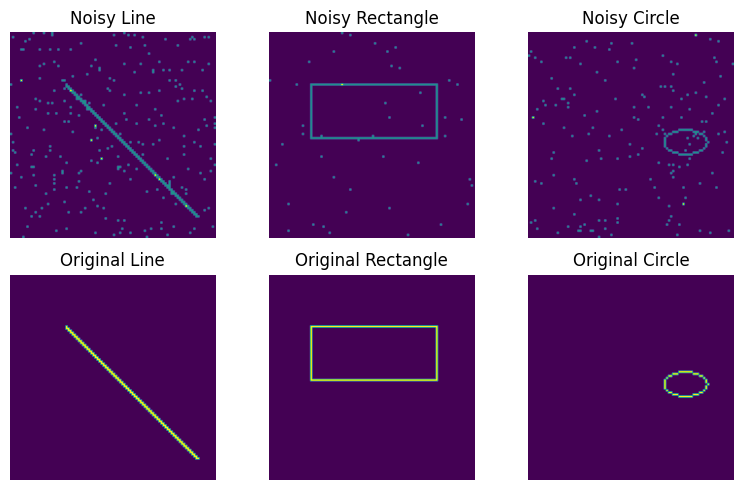

In [11]:
line_idx = np.random.randint(0, 5000)
rectangle_idx = np.random.randint(5000, 10000)
circle_idx = np.random.randint(10000, 15000)

fig, ax = plt.subplots(2, 3, figsize=(8, 5))

ax[0,0].imshow(noisy_data[line_idx])
ax[0,0].set_title('Noisy Line')
ax[0,0].axis('off')
ax[0,1].imshow(noisy_data[rectangle_idx])
ax[0,1].set_title('Noisy Rectangle')
ax[0,1].axis('off')
ax[0,2].imshow(noisy_data[circle_idx])
ax[0,2].set_title('Noisy Circle')
ax[0,2].axis('off')
ax[1,0].imshow(data[line_idx])
ax[1,0].set_title('Original Line')
ax[1,0].axis('off')
ax[1,1].imshow(data[rectangle_idx])
ax[1,1].set_title('Original Rectangle')
ax[1,1].axis('off')
ax[1,2].imshow(data[circle_idx])
ax[1,2].set_title('Original Circle')
ax[1,2].axis('off')

plt.tight_layout()
plt.show()

In [12]:
np.save('shapes_data_noisy.npy', noisy_data)
np.save('shapes_labels_noisy.npy', noisy_labels)
np.save('shapes_snrs.npy', snrs)
np.save('shapes_data.npy', data)
np.save('shapes_labels.npy', labels)